In [1]:
import re

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

## 1. Extract data

In [3]:
pat = r"\= Message size: (\d*) -> time: (.*)"

In [4]:
paths = [
    ('local', "results_local.txt"),
    ('turso', "results_turso.txt")
]

In [5]:
records = []

for name, path in paths:
    with open(path) as f:
        data = f.read().split('\n')
    for line in data:
        out = re.findall(pat, line)

        records.append({
            'machine': name,
            'message_size': eval(out[0][0]),
            'time': eval(out[0][1])
        })

df = pd.DataFrame.from_records(records)

df.head()

,machine,message_size,time
0,local,32,0.000022
1,local,654,0.000006
2,local,5324,0.000191
3,local,6343,0.000027
4,local,232,0.000005


## 2. Calculate latency and bandwidth

In [6]:
df['message_size_megabyte'] = df['message_size'] * 4 / 1024 / 1024

In [7]:
bandwidth, latency = [], []

for name in df['machine'].unique():
    df_ = df[df['machine'] == name]

    ones = np.ones((len(df_),))

    features = np.concatenate((df_['message_size_megabyte'].to_numpy()[:, None], ones[:, None]), axis=-1)
    target = df_['time'].to_numpy().reshape(-1, 1)
    coef = LinearRegression().fit(features, target).coef_

    bandwidth.append({
        'machine': name,
        'value': 1 / (coef[0, 0] + 1e-6)
    })
    latency.append({
        'machine': name,
        'value': coef[0, 1]
    })

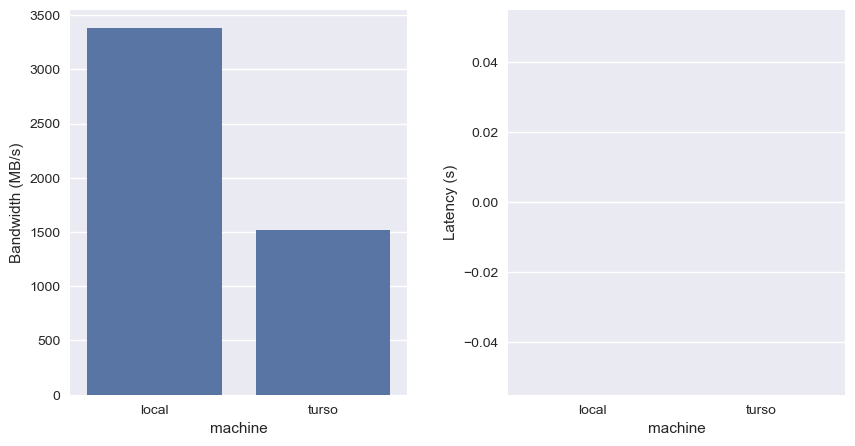

In [15]:
fig = plt.figure(figsize=(10, 5))

df_bandwidth = pd.DataFrame.from_records(bandwidth)
ax = fig.add_subplot(121)
sns.barplot(df_bandwidth, x='machine', y='value', ax=ax)
ax.set_ylabel('Bandwidth (MB/s)')

df_latency = pd.DataFrame.from_records(latency)
ax = fig.add_subplot(122)
sns.barplot(df_latency, x='machine', y='value', ax=ax)
ax.set_ylabel('Latency (s)')

fig.subplots_adjust(wspace=0.3)

## 3. Plot adidtional

In [25]:
df2 = df.copy()

df2 = df2\
    .groupby(by=['machine', 'message_size'])\
    .mean()\
    .drop(columns='message_size_megabyte')\
    .reset_index()\
    .sort_values(by='message_size')\
    .astype({'message_size': str})

df2.head()

,machine,message_size,time
0,local,32,0.000023
16,turso,32,0.002665
17,turso,232,0.000010
1,local,232,0.000005
18,turso,312,0.000019


Text(0.5, 0, 'Message size')

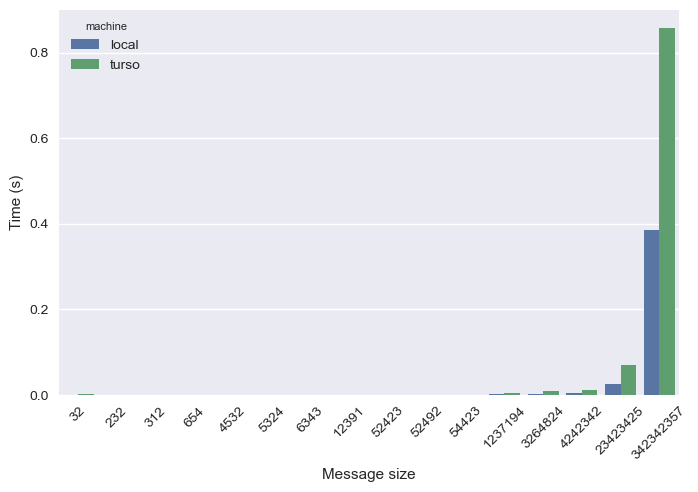

In [28]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

sns.barplot(df2, x='message_size', y='time', hue='machine', ax=ax)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylabel("Time (s)")
ax.set_xlabel("Message size")